# Advanced Exercise project 3 – CNN for time series classification (Audio)

In this project I worked with .wav audio files and used them for time series classification.

I found this code when I was searching for how to do CNN on audio files, but unfortunately, I forgot to save the link or note down where it came from. I can’t trace the original source anymore, and I also don’t know exactly where the audio recordings came from.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tqdm.keras import TqdmCallback

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_3/"
os.chdir(folder_path)

In [ ]:
audio_path = folder_path + "data/recordings"
output_path = folder_path + "data/output"

In [ ]:
parent_list = os.listdir(audio_path)
for i in range(10):
    print(parent_list[i])

1_nicolas_8.wav
6_theo_30.wav
6_george_45.wav
3_theo_35.wav
8_lucas_6.wav
6_lucas_43.wav
1_george_41.wav
0_george_9.wav
4_lucas_0.wav
5_george_40.wav


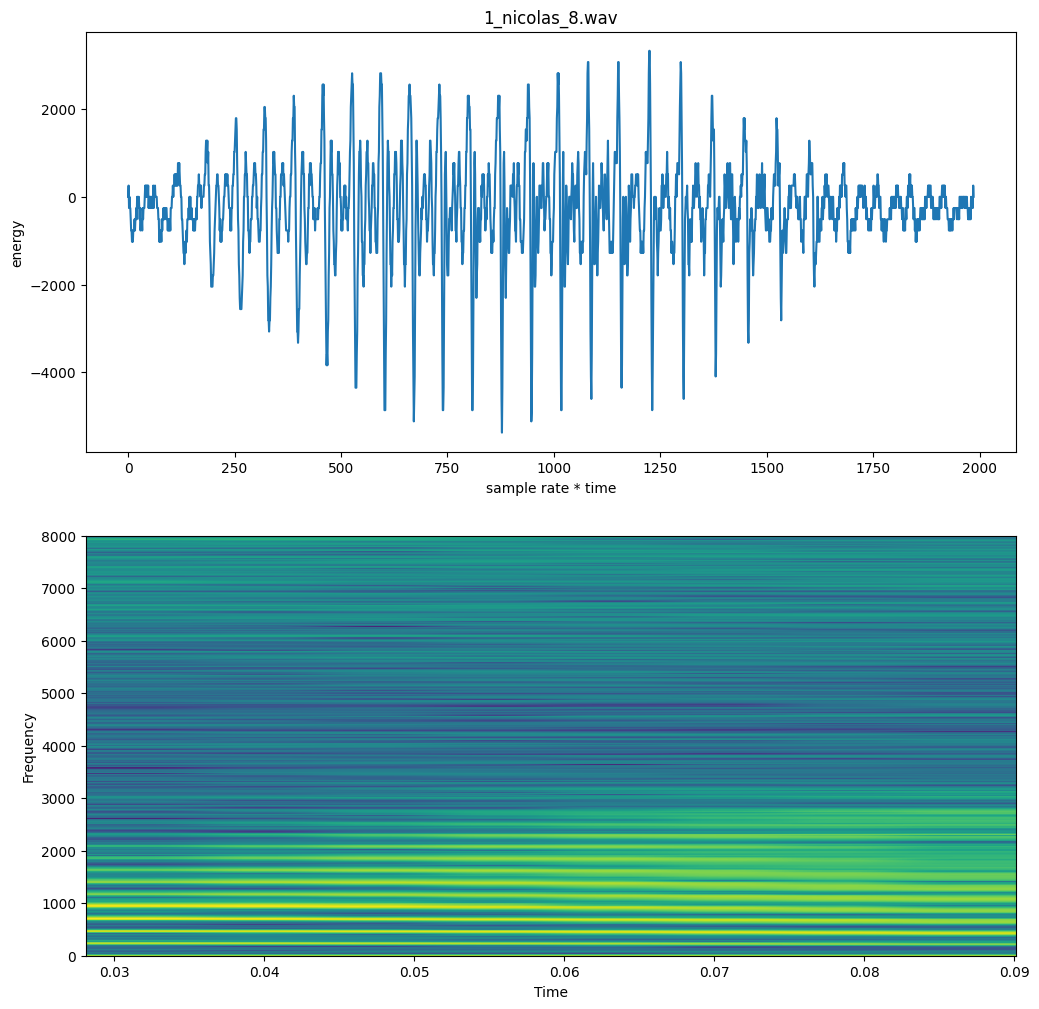

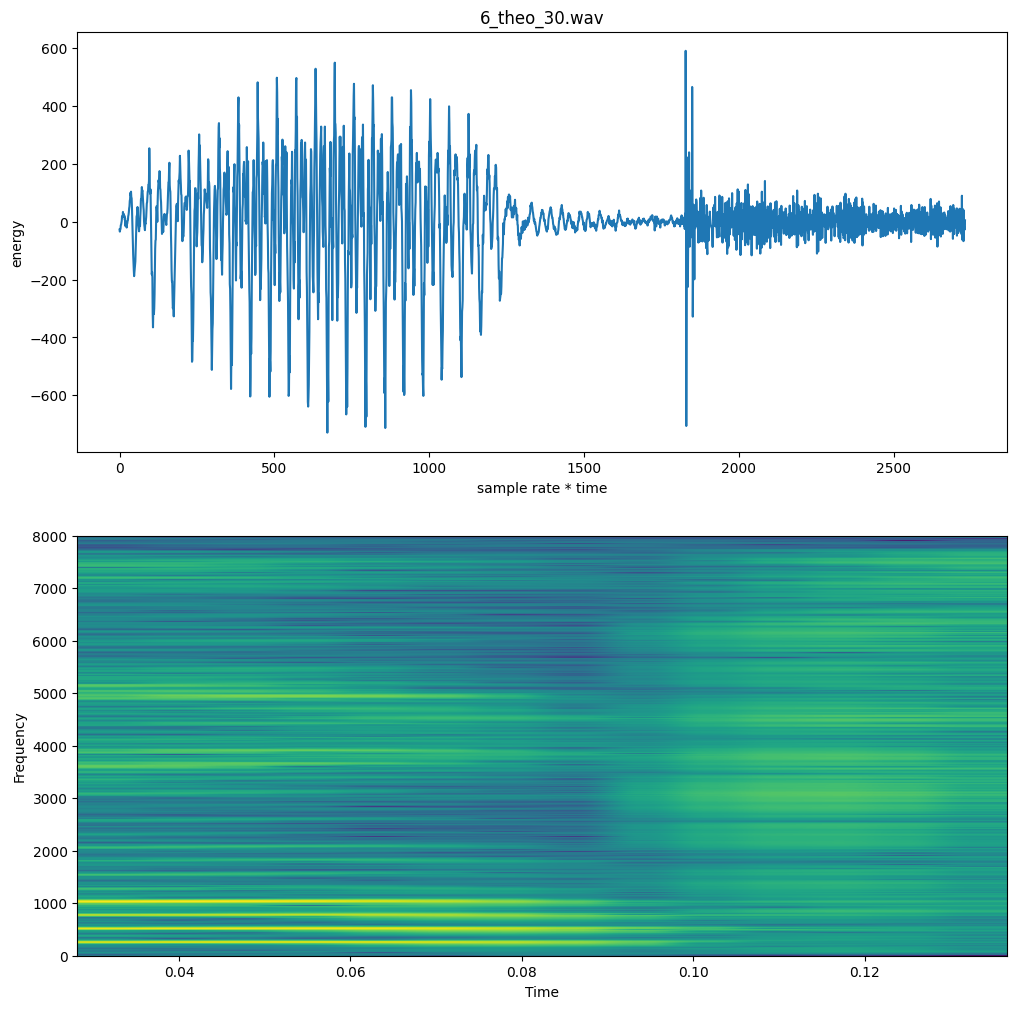

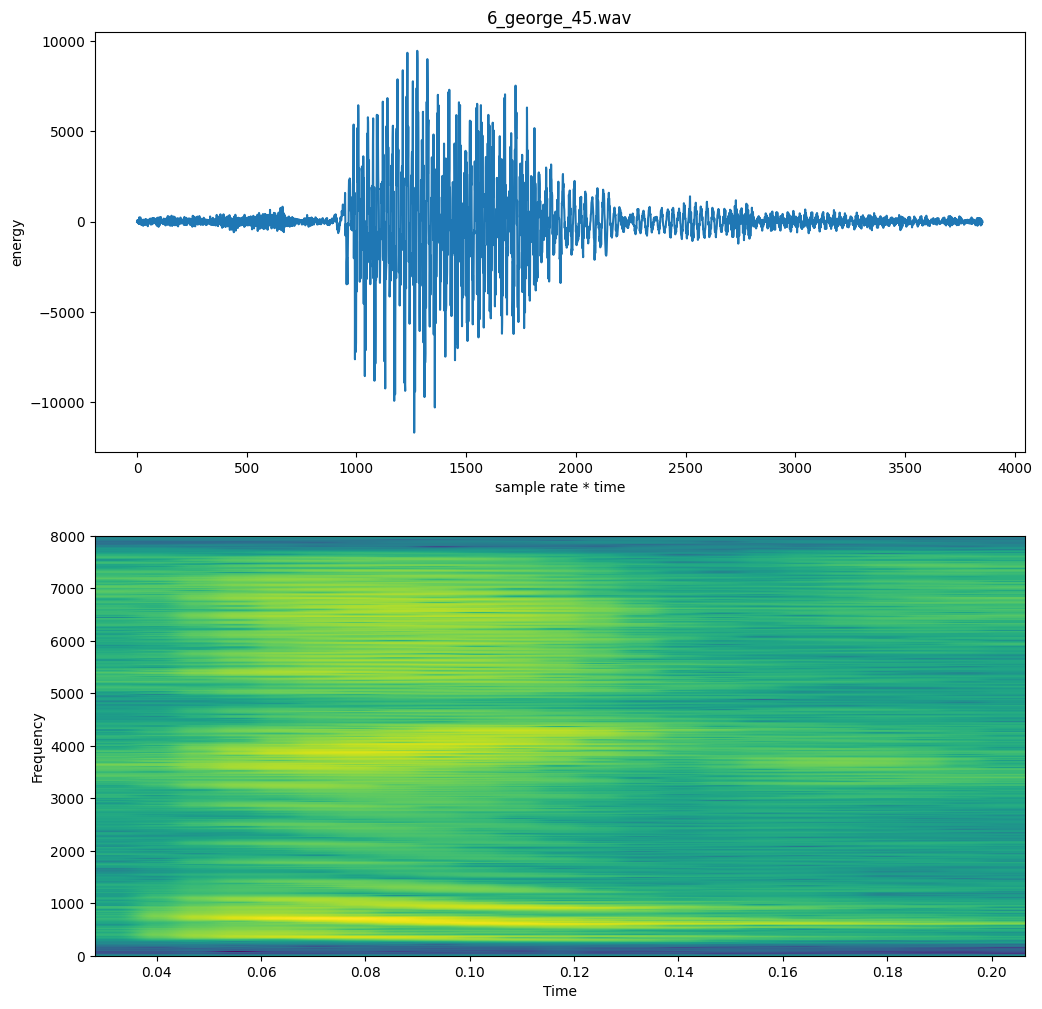

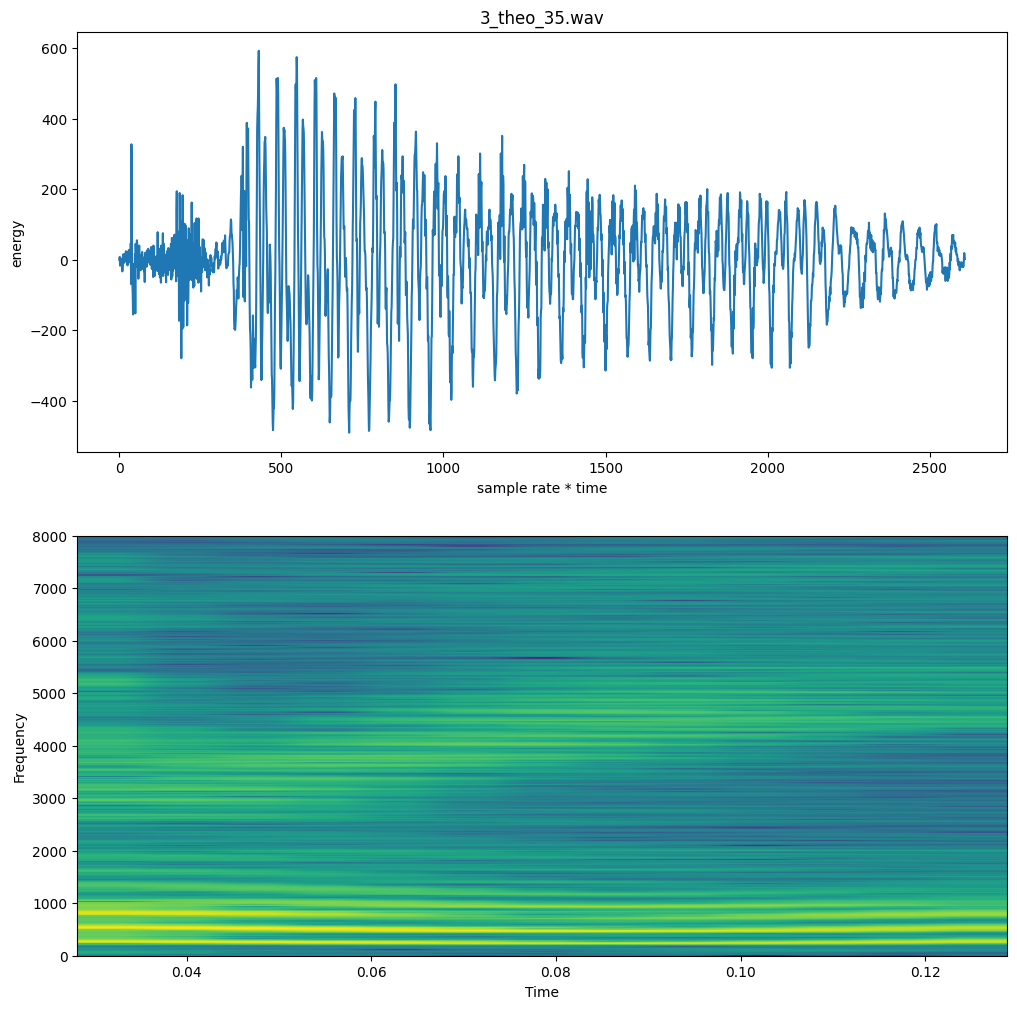

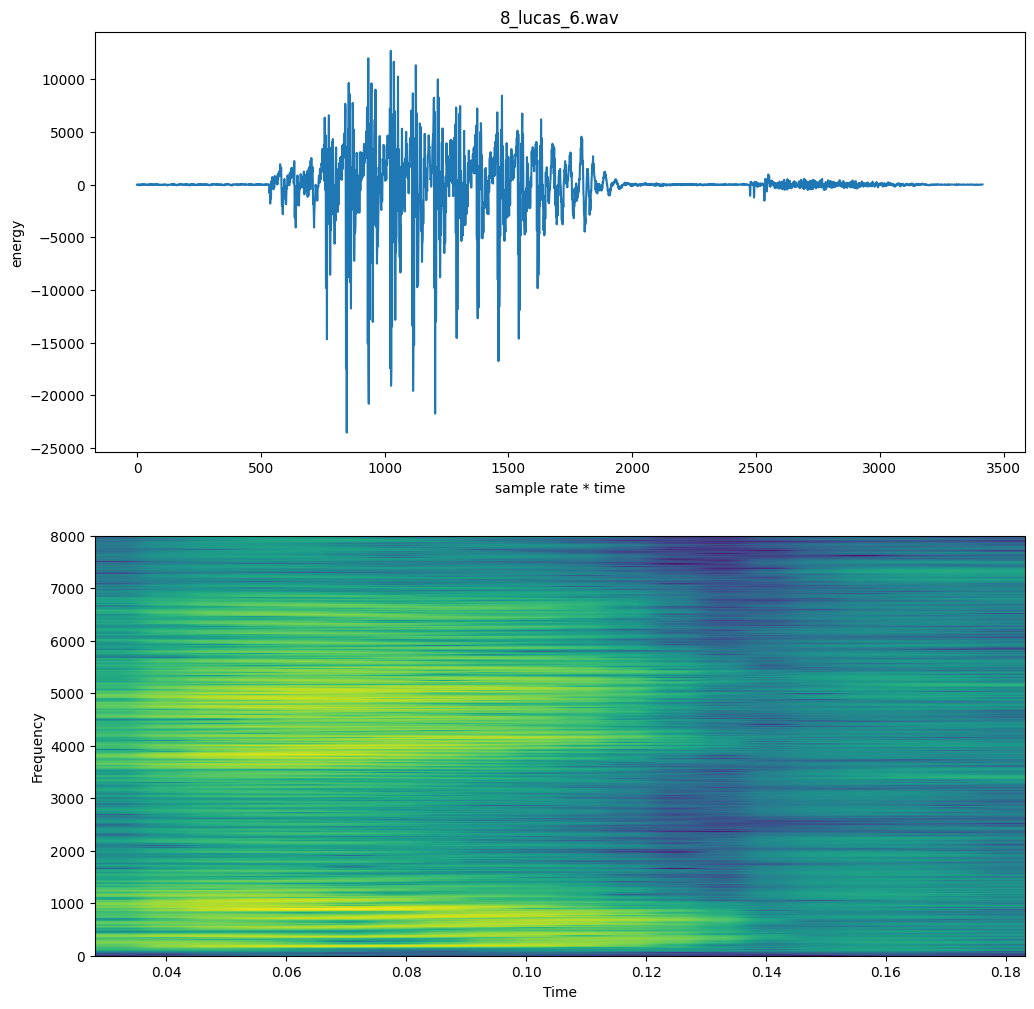

In [ ]:
# Plot first 5 WAV files as a waveform and a frequency spectrum
for i in range(5):
    signal_wave = wave.open(os.path.join(audio_path, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

In [ ]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(output_path, 'audio-images')):
    os.mkdir(os.path.join(output_path, 'audio-images'))

for filename in os.listdir(audio_path):
    if "wav" in filename:
        file_path = os.path.join(audio_path, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(output_path, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(output_path, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])

# File names for class 1
path_list = os.listdir(os.path.join(output_path, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_1
class_6
class_3
class_8
class_0
class_4
class_5
class_7
class_9
class_2

A few example files: 

1_nicolas_8.png
1_george_41.png
1_yweweler_34.png
1_yweweler_20.png
1_theo_14.png
1_theo_28.png
1_yweweler_21.png
1_yweweler_35.png
1_nicolas_9.png
1_theo_29.png


In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(output_path, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(output_path, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 471 files belonging to 10 classes.
Using 377 files for training.
Found 471 files belonging to 10 classes.
Using 94 files for validation.


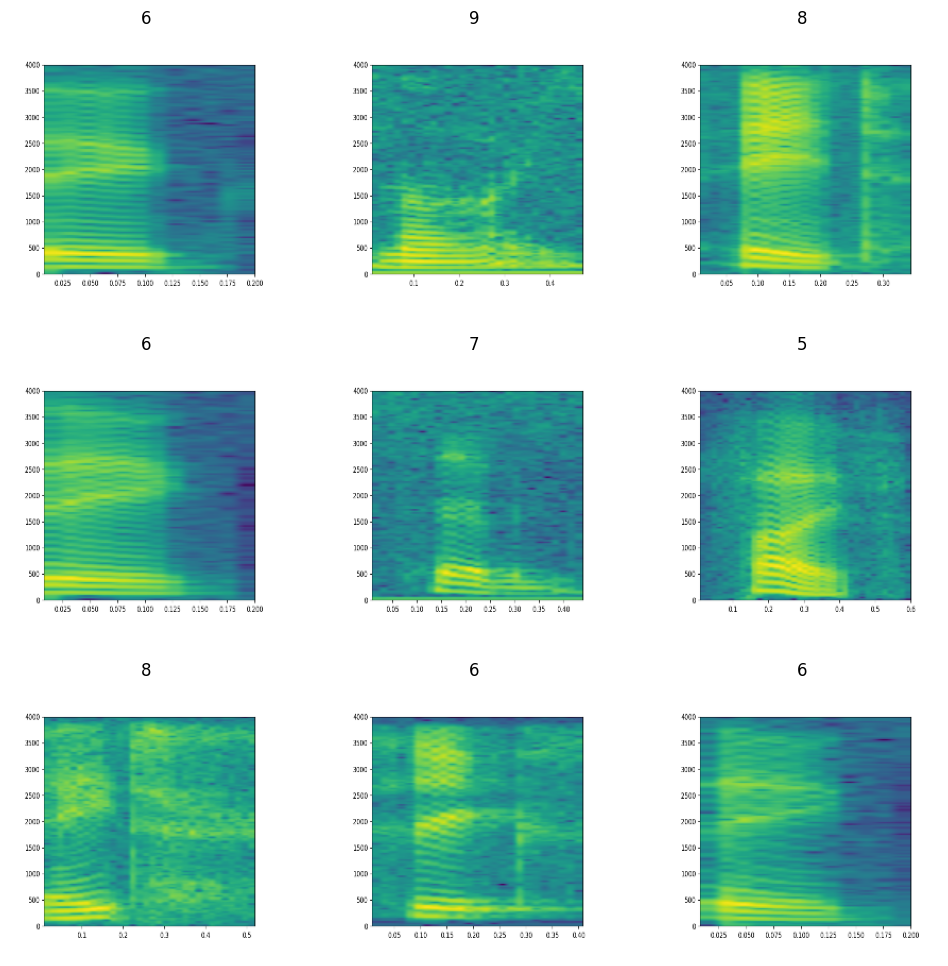

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [ ]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [ ]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],

)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, verbose=0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

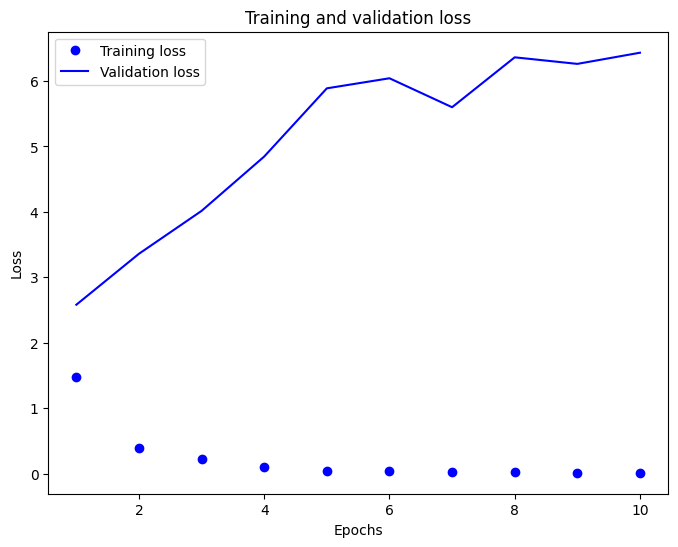

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

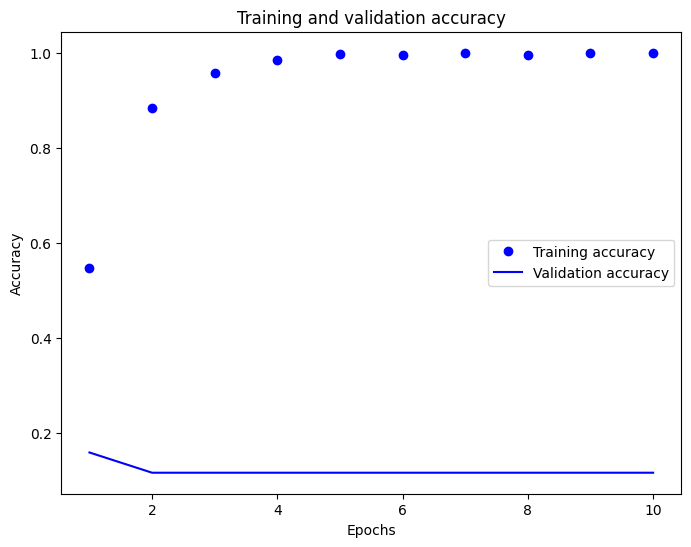

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 6.430651, final accuracy: 0.117021


### Personal Analysis / Refelection

Eventhough this Notebook was by no means a success, I still learned a lot about raw audio and visual representations of it. I learned that frequency-based patterns can be used for classifying audio, not just waveforms.

I was really impressed by how complex and well-structured the CNN architecture was, it had 3 Conv2D layers in total with multiple BatchNormalization

The CNN took spectrogram images of shape (256, 256, 3) and was trained using sparse categorical crossentropy. It was optimized using RMSprop and trained over 10 epochs. and Dropout layers.

However, one thing that stood out to me was the very high training accuracy (100%) but very low validation accuracy (only ~11.7%). This clearly showed that the model was overfitting, which is weird because I swear this code was an example I found online.

This type of approach might be useful in speech command recognition, speaker identification and also maybe wildlife sounds classsification.